In [42]:
import os
import pickle
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt

from collections import Counter, defaultdict
from nltk import ngrams
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

In [43]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

In [44]:
df=pd.read_csv("../data/train.csv", encoding='utf-8-sig')

In [45]:
df.head()

,title,full_text,generated
0,카호올라웨섬,카호올라웨섬은 하와이 제도를 구성하는 8개의 화산섬 가운데 하나로 면적은 115.5...,0
1,청색거성,"천문학에서 청색거성(靑色巨星, )은 광도 분류에서 III형(거성) 또는 II형(밝은...",0
2,엘자스-로트링겐 평의회 공화국,엘자스-로트링겐 평의회 공화국은 1차대전 말기 독일 혁명 와중에 엘자스-로트링겐에서...,0
3,윌리엄 페니 브룩스,"윌리엄 페니 브룩스(, 1809년 8월 13일 ~ 1895년 12월 11일)는 잉글...",0
4,미그로,"미그로 또는 미그로스(""Migros"")는 스위스 최대 소매 회사이자, 최대 슈퍼마켓...",0


In [5]:
# "title"+" "+"full_text"
df['title_fulltext'] = df['title'] + ' ' + df['full_text']

### 단어 분포 시각화

In [6]:
df['word_count'] = df['title_fulltext'].apply(lambda x: len(x.split()))
df['unique_word_count'] = df['title_fulltext'].apply(lambda x: len(set(x.split())))
df['unique_word_ratio'] = df['unique_word_count'] / df['word_count']

In [10]:
df['word_count'].describe()

count    97172.000000
mean       513.470526
std        740.238125
min         53.000000
25%        203.000000
50%        293.000000
75%        516.000000
max      22447.000000
Name: word_count, dtype: float64

In [11]:
df['unique_word_count'].describe()

count    97172.000000
mean       384.229706
std        453.000878
min         28.000000
25%        172.000000
50%        241.000000
75%        406.000000
max      11408.000000
Name: unique_word_count, dtype: float64

In [12]:
df['unique_word_ratio'].describe()

count    97172.000000
mean         0.810010
std          0.082821
min          0.129630
25%          0.765537
50%          0.822581
75%          0.869048
max          1.000000
Name: unique_word_ratio, dtype: float64

In [13]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf' 
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['axes.unicode_minus'] = False 

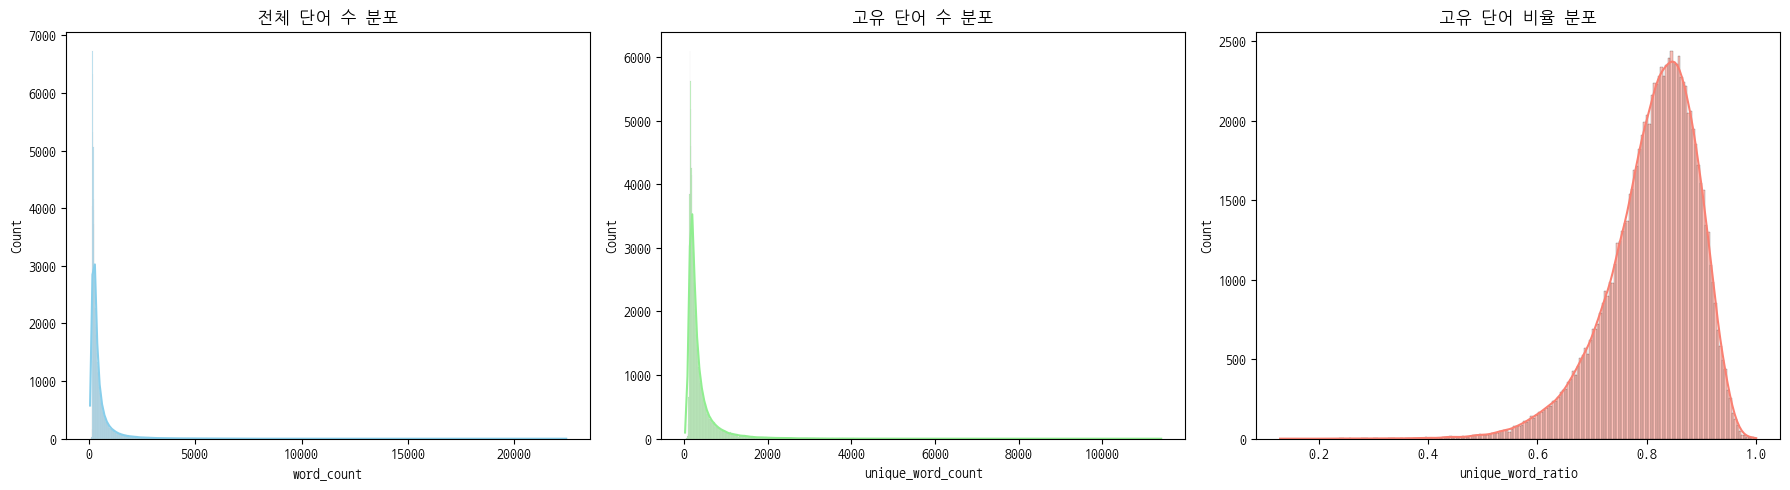

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# word_count
sns.histplot(df['word_count'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('전체 단어 수 분포')
axes[0].set_xlabel('word_count')

# unique_word_count
sns.histplot(df['unique_word_count'], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('고유 단어 수 분포')
axes[1].set_xlabel('unique_word_count')

# unique_word_ratio
sns.histplot(df['unique_word_ratio'], kde=True, ax=axes[2], color='salmon')
axes[2].set_title('고유 단어 비율 분포')
axes[2].set_xlabel('unique_word_ratio')

plt.tight_layout()
plt.show()

##### generated(0,1)의 단어 분포 시각화

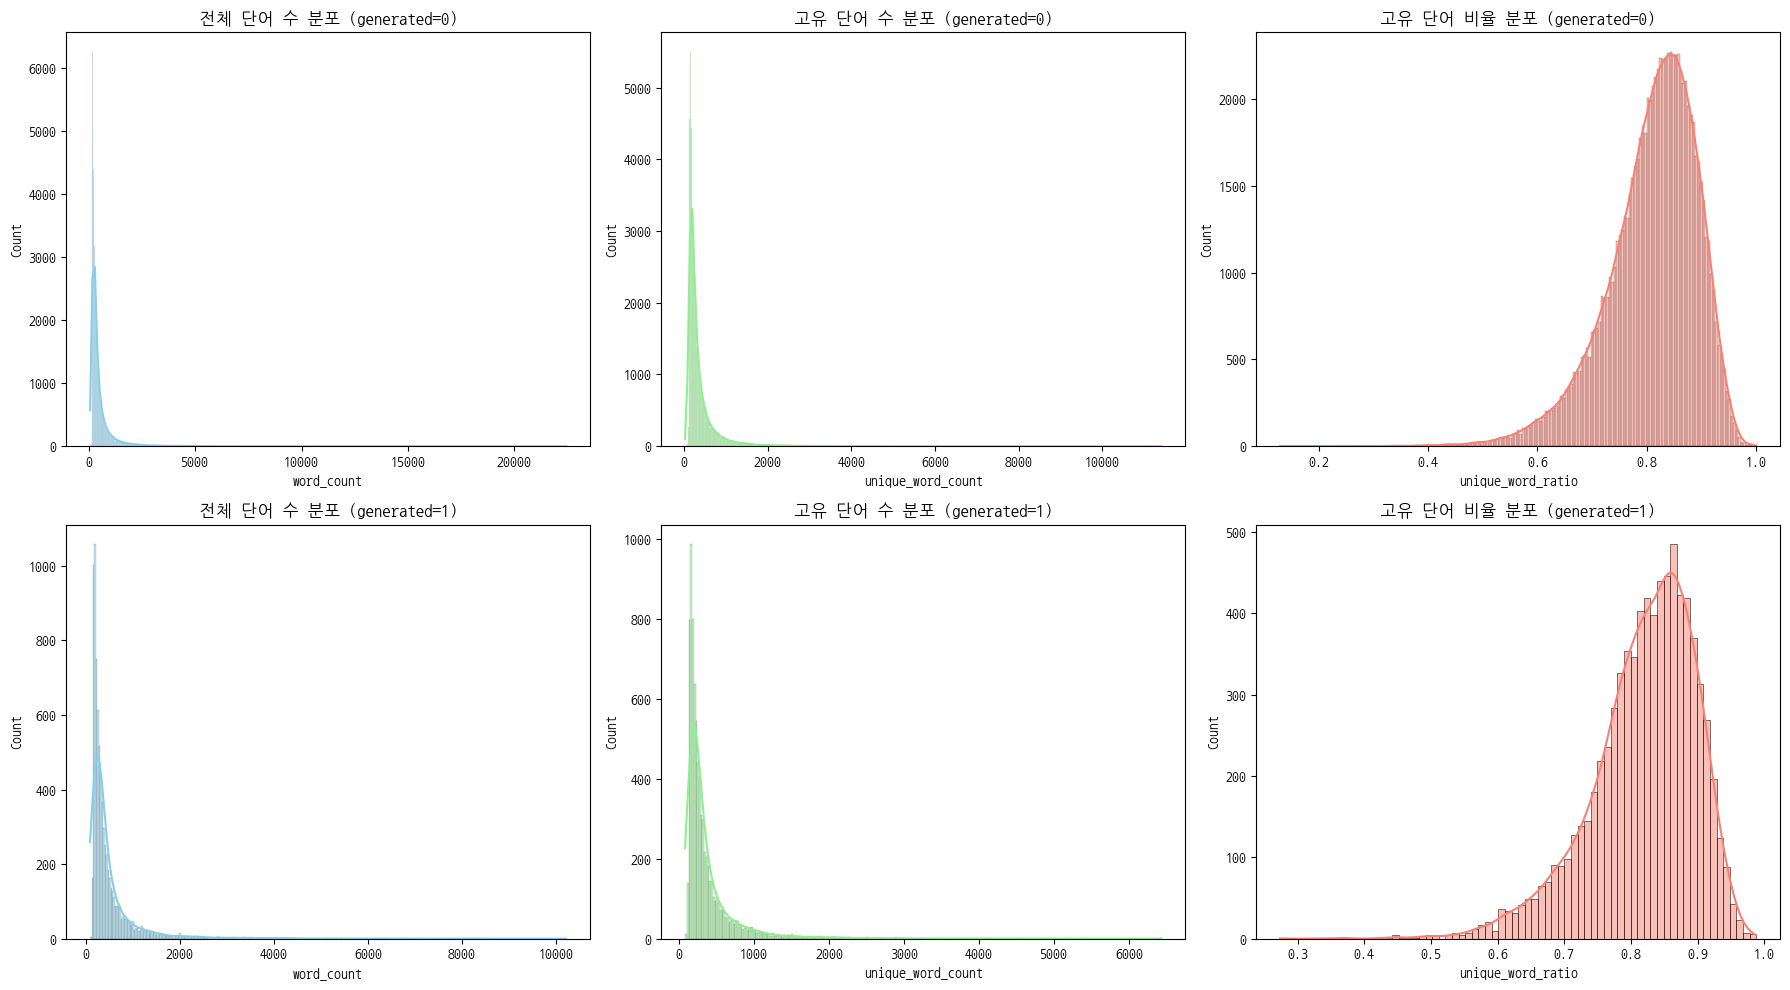

In [9]:
# generated
df_0 = df[df['generated'] == 0]
df_1 = df[df['generated'] == 1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 첫 번째 행, generated == 0
sns.histplot(df_0['word_count'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('전체 단어 수 분포 (generated=0)')
axes[0, 0].set_xlabel('word_count')

sns.histplot(df_0['unique_word_count'], kde=True, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('고유 단어 수 분포 (generated=0)')
axes[0, 1].set_xlabel('unique_word_count')

sns.histplot(df_0['unique_word_ratio'], kde=True, ax=axes[0, 2], color='salmon')
axes[0, 2].set_title('고유 단어 비율 분포 (generated=0)')
axes[0, 2].set_xlabel('unique_word_ratio')

# 두 번째 행: generated == 1
sns.histplot(df_1['word_count'], kde=True, ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('전체 단어 수 분포 (generated=1)')
axes[1, 0].set_xlabel('word_count')

sns.histplot(df_1['unique_word_count'], kde=True, ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('고유 단어 수 분포 (generated=1)')
axes[1, 1].set_xlabel('unique_word_count')

sns.histplot(df_1['unique_word_ratio'], kde=True, ax=axes[1, 2], color='salmon')
axes[1, 2].set_title('고유 단어 비율 분포 (generated=1)')
axes[1, 2].set_xlabel('unique_word_ratio')

plt.tight_layout()
plt.show()


In [14]:
df_0["word_count"].describe()

count    89177.000000
mean       513.108638
std        743.099581
min         53.000000
25%        203.000000
50%        292.000000
75%        516.000000
max      22447.000000
Name: word_count, dtype: float64

In [15]:
df_0['unique_word_count'].describe()

count    89177.000000
mean       383.629759
std        453.896196
min         28.000000
25%        172.000000
50%        241.000000
75%        406.000000
max      11408.000000
Name: unique_word_count, dtype: float64

In [16]:
df_0['unique_word_ratio'].describe()

count    89177.000000
mean         0.809248
std          0.083097
min          0.129630
25%          0.764405
50%          0.821839
75%          0.868421
max          1.000000
Name: unique_word_ratio, dtype: float64

In [17]:
df_1["word_count"].describe()

count     7995.000000
mean       517.507067
std        707.569265
min         89.000000
25%        205.000000
50%        300.000000
75%        516.000000
max      10216.000000
Name: word_count, dtype: float64

In [18]:
df_1['unique_word_count'].describe()

count    7995.000000
mean      390.921576
std       442.864463
min        83.000000
25%       177.000000
50%       249.000000
75%       409.000000
max      6427.000000
Name: unique_word_count, dtype: float64

In [19]:
df_1['unique_word_ratio'].describe()

count    7995.000000
mean        0.818507
std         0.079178
min         0.273839
25%         0.776096
50%         0.830424
75%         0.875552
max         0.987879
Name: unique_word_ratio, dtype: float64

### 문단 개수

In [53]:
# 줄바꿈 및 특수 문자 확인
pd.set_option('display.max_colwidth', None)
first_idx = df.index[df['generated'] == 1][0]
row = df.loc[first_idx]
for col in df.columns:
    print(f"{col}:{repr(row[col])}\n{'-'*40}")

title:'수난곡'
----------------------------------------
full_text:'수난곡(受難曲)은 배우의 연기 없이 무대에 올려지는 성악을 주로 한 종합 예술이다. 이러한 의미에서 오라토리오와 유사하지만, 성경의 사복음서를 기반으로 한 예수 그리스도의 생애를 주로 다루고 있다는 점에서 차이가 있다. 또한 이는 주로 독일 계열 작곡가들에게 쓰인 개념이다. 수난 또는 수난곡을 뜻하는 영어 \'Passion\'은 2세기에 나타난 라틴어 "passio"에서 유래하며, 예수의 생애와 고난이란 의미를 담고 있다.\n사복음서에 기록된 예수님의 수난 이야기는 마태오, 마르코, 루카, 요한 복음서에 각각 담겨 있습니다. 이를 바탕으로 \'마태오 수난곡\', \'마르코 수난곡\', \'루카 수난곡\', \'요한 수난곡\'이라는 4개의 작품이 만들어졌죠. 이들 작품은 예수님의 고난과 십자가 처형을 다루고 있습니다.\n옛날부터 성(聖) 금요일이나 성주간(聖週間)에는 수난극이나 이와 비슷한 행사를 하였다. 12세기경부터 복음서에 따라 그리스도 수난의 이야기를 3인의 신부가, 한 사람은 복음사가(福音史家)의 역(테너)을, 또 한 사람은 그리스도의 역(베이스)을, 나머지 한 사람은 군중의 역(알토)을 맡아 낭독조로 노래하는 습관이 되었다. 이것이 그 뒤의 수난곡의 기원이다. 이와 같은 형식으로 된 수난곡을 \'코랄 수난곡\'이라 하며, 대략 17세기경까지 만들어졌다. 특히 유명한 작품으로는 쉬츠의 《마태오 수난곡》이 있다. 이와 함께 16세기-17세기에는 다른 타입의 \'모테토 수난곡\'이 생겼다. 이것은 텍스트의 전체를 등장인물의 수와 관계없이 일관하여 모테토풍의 다성부 합창으로 노래한다. 음악사적으로 가장 중요한 것은 17세기 중엽경에 성립한 \'오라토리오 수난곡\'이다. 이것은 일반적으로 성서의 텍스트를 자유롭게 시로 만들어 코랄 또는 솔로의 아리아 형식으로 삽입되어 있기 때문에, 형식적으로도 아리아, 레치타티보, 합창, 통주저음, 기악반주를 썼으

In [ ]:
# 줄바꿈 ('\n') 개수
df['newline_cnt'] = df['full_text'].apply(lambda x: x.count('\n'))

In [54]:
df['newline_cnt'].describe()

count    97172.000000
mean        11.620549
std         16.862932
min          0.000000
25%          5.000000
50%          7.000000
75%         13.000000
max       1728.000000
Name: newline_cnt, dtype: float64

In [55]:
# 문단 자르기
def split_paragraphs(df):
    chuncks=[]
    for _, row in df.iterrows():
        title=row["title"]
        paragraphs = [p for p in row['full_text'].split('\n') if p.strip()]
        for idx, paragraph in enumerate(paragraphs):
            chuncks.append({
                "title":title,
                "paragraph_index":idx,
                "paragraph_text":paragraph.strip()
            })
    return pd.DataFrame(chuncks)


In [56]:
split_df=split_paragraphs(df)

In [57]:
split_df.head()

,title,paragraph_index,paragraph_text
0,카호올라웨섬,0,"카호올라웨섬은 하와이 제도를 구성하는 8개의 화산섬 가운데 하나로 면적은 115.5km2, 높이는 452m이다. 하와이 제도에서 가장 작은 화산섬이자 무인도이며 길이는 18km, 너비는 10km이다."
1,카호올라웨섬,1,마우이섬에서 남서쪽으로 약 11km 정도 떨어진 곳에 위치하며 라나이섬의 남동쪽에 위치한다. 고도가 낮고 북동쪽에서 불어오는 무역풍을 통해 산악 지대에서 내리는 비를 형성하지 못하기 때문에 건조한 기후를 띤다. 마우이섬 화산의 비그늘에 속해 있기 때문에 섬 전체 면적의 1/4 이상이 부식되어 있다.
2,카호올라웨섬,2,"1000년경부터 사람이 거주했으며 해안 지대에는 소규모 임시 어촌이 형성되었다. 섬 안에는 주민들이 돌로 만든 제단에서 종교 의식을 거행한 흔적들, 주민들이 암석이나 평평한 돌에 그림을 그린 흔적들이 남아 있다. 1778년부터 1800년대까지 이 지역을 지나 항해하던 사람들의 보고에 따르면 카호올라웨섬은 무인도였고 나무도 물도 없는 불모지였다고 한다."
3,카호올라웨섬,3,1830년대에는 하와이 왕국의 카메하메하 3세 국왕에 의해 남자 죄수들의 유형지로 사용되었지만 1853년에 폐지되었다. 1858년에는 하와이 정부가 목장 사업가들에게 카호올라웨섬을 양도했지만 가뭄과 과도한 방목으로 인해 땅이 말라갔다. 또한 강한 무역풍으로 인해 표토의 대부분이 날아가면서 붉은 경반층만 남게 되었다.
4,카호올라웨섬,4,1910년부터 1918년까지 하와이 준주가 섬의 원래 모습을 복원하기 위해 이 섬을 천연보호구역으로 지정했지만 큰 성과를 거두지 못했다.


In [58]:
len(split_df)

1226364

### 문단별 형태소 분석 및 품사별 토큰화

In [59]:
target_pos = [
    'Noun', 'Verb', 'Adjective', 'Josa', 'Eomi', 'Adverb', 'Conjunction',
    'Exclamation', 'Determiner', 'PreEomi', 'Suffix', 'Alpha', 'Number',
    'Foreign', 'Punctuation'
]

okt = Okt()


In [62]:
def use_okt(df):
    okt = Okt()
    target_pos = [
        'Noun', 'Verb', 'Adjective', 'Josa', 'Eomi', 'Adverb', 'Conjunction',
        'Exclamation', 'Determiner', 'PreEomi', 'Suffix', 'Alpha', 'Number',
        'Foreign', 'Punctuation'
    ]
    def pos_dict_per_text(text):
        pos_dict = {pos: [] for pos in target_pos}
        for word, p in okt.pos(text, stem=True):
            if p in pos_dict:
                pos_dict[p].append(word)
        return pos_dict
    pos_dicts = df['paragraph_text'].progress_apply(pos_dict_per_text)
    for pos in target_pos:
        df[f'{pos.lower()}'] = pos_dicts.apply(lambda d: ' '.join(d[pos]))
    
    return df

In [63]:
split_pos_df=use_okt(split_df)

  6%|▌         | 68172/1226364 [08:51<2:30:32, 128.22it/s]


KeyboardInterrupt: 

### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['title_fulltext'])

In [ ]:
print(len(vectorizer.vocabulary_))

In [ ]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [ ]:
nonzero_word_count = (tfidf_matrix > 0).sum(axis=1)

In [ ]:
df['tfidf_word_count'] = np.array((tfidf_matrix > 0).sum(axis=1)).flatten()